In [1]:
from matplotlib import pyplot as plt
import numpy as np
#from scipy.signal import convolve2d
from PIL import Image
from ipywidgets import interact

In [2]:
%ls imgs

cameraman.tif       lena_gray_512.tif  sent.jpg
lena_color_512.tif  peppers_color.jpg


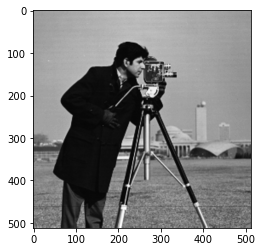

In [3]:
im = Image.open('imgs/cameraman.tif')
ar = np.asarray(im)
plt.imshow(ar,'gray');

In [4]:
def konw(ar,bits=False):
    ar = ar.copy()
    ar = (ar - ar.min()) / (ar.max() - ar.min())
    
    if bits:
        ar = ar * bits
    return ar

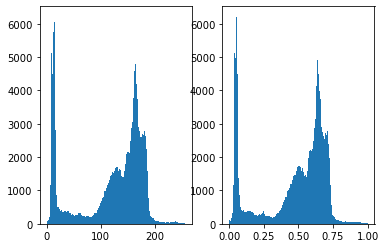

In [5]:
a1 = konw(ar)
f,ax = plt.subplots(1,2)
ax[0].hist(ar.ravel(),bins=256);
ax[1].hist(a1.ravel(),bins=256);


$$
newPix_{r,c} = \sum_{i=r-1,j=c-1}^{r+1,c+1}(im_{i,j}\cdot kernel_{i,j})\quad\diagup\quad
\sum kernel
$$

$$
\begin{array}{|c|c|c|}\hline
r-1,c-1 & r-1,c &r-1,c+1\\\hline
r,  c-1 &  r,c  &r,  c+1\\\hline
r+1,c-1 & r+1,c &r+1,c+1\\\hline
\end{array}
$$


$$kernel =
\begin{array}{|c|c|c|}\hline
0  & -1 &  0\\\hline
-1 &  5 & -1\\\hline
0  & -1 &  0\\\hline
\end{array}
$$
$$
sk = \sum kernel = -4+5 = 1
$$

$$
\begin{array}{|c|c|c|}\hline
1 & 2 & 3\\\hline
2 & 1 & 3\\\hline
3 & 2 & 1\\\hline
\end{array} \qquad
*
\begin{array}{|c|c|c|}\hline
0  & -1 &  0\\\hline
-1 &  5 & -1\\\hline
0  & -1 &  0\\\hline
\end{array}
=
\begin{array}{|c|c|c|}\hline
1*0 & 2*(-1) & 3*0\\\hline
2*(-1) & 1*5 & 3*(-1)\\\hline
3*0 & 2*(-1) & 1*0\\\hline
\end{array}
=
\begin{array}{|c|c|c|}\hline
 0 & -2 &  0\\\hline
-2 &  5 & -3\\\hline
 0 & -2 &  0\\\hline
\end{array}
$$

$$newPix=
\begin{array}{|c|c|c|}\hline
 0 & -2 &  0\\\hline
-2 &  5 & -3\\\hline
 0 & -2 &  0\\\hline
\end{array}
/sk
= (0-2+0-2+5-3+0-2+0) / 1 = -4
$$

In [6]:
tmp = np.arange(3*3).reshape(3,3)
np.pad(tmp,1)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 2, 0],
       [0, 3, 4, 5, 0],
       [0, 6, 7, 8, 0],
       [0, 0, 0, 0, 0]])

In [7]:
np.pad(tmp,1,mode='edge')

array([[0, 0, 1, 2, 2],
       [0, 0, 1, 2, 2],
       [3, 3, 4, 5, 5],
       [6, 6, 7, 8, 8],
       [6, 6, 7, 8, 8]])

In [8]:
def elemConv(window,ker):
    if ker.sum() > 0:
        sk = ker.sum()
    else:
        sk = 1
    return (window * ker).sum() / sk

In [9]:
a1 = ar[:3,:3].copy()
# high-pass kernel
ker = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
print(a1,ker,sep='\n\n')
elemConv(a1,ker)

[[156 157 160]
 [156 157 159]
 [158 157 156]]

[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]


156.0

In [10]:
def myConv2d(ar,ker,ret=False):
    out = np.zeros_like(ar,dtype=np.float64)
    #pad = ker.shape[0]-2
    pad = 1
    ar = np.pad(ar.copy(),pad)
    
    for row in range(1,ar.shape[0]-2):
        for col in range(1,ar.shape[1]-2):
            window = ar[row-1:row+2, col-1:col+2]
            pix = elemConv(window,ker)
            out[row,col] = pix
    out = konw(out,1)
    
    ar = ar[pad:-pad,pad:-pad]

    f,axs = plt.subplots(1,2,figsize=(10,5)) 
    axs[0].imshow(ar,'gray')
    axs[0].set_title('original')
    axs[1].imshow(out,'gray')
    axs[1].set_title('filtered')
    plt.show()
    
    if ret:
        return out

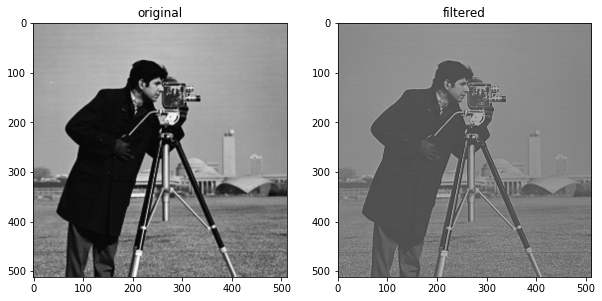

In [11]:
a2 = myConv2d(ar,ker,ret=1)

In [12]:
ker1 = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
ker2 = ker1.T
print(ker1, ker2,sep='\n\n')

[[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]

[[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


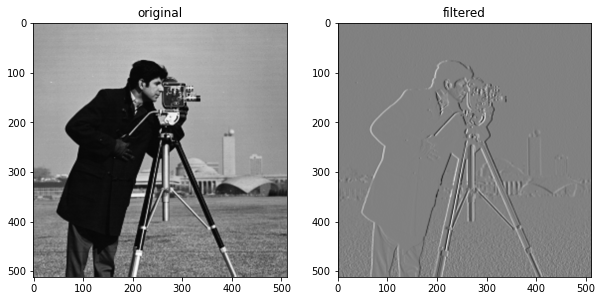

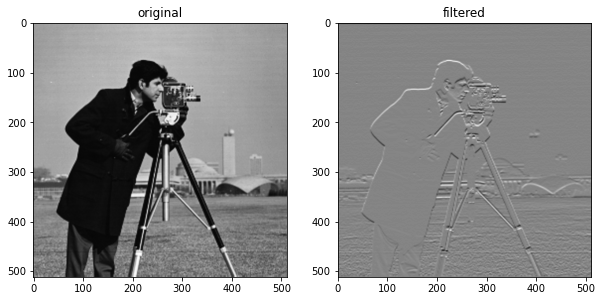

In [13]:
s1 = myConv2d(ar,ker1,ret=1)
s2 = myConv2d(ar,ker2,ret=1)

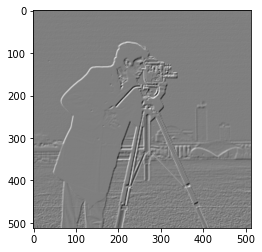

In [22]:
ss = (s1**2 + s2**2)**0.5
ss = konw(ss,255)
plt.imshow(ss,'gray');

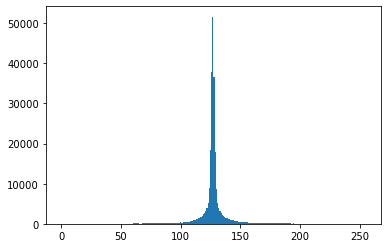

In [23]:
plt.hist(ss.ravel(),bins=256);

In [24]:
def ftmp(x):
    idx = ss < x
    ar = ss.copy()
    ar[idx] = 0
    ar[~idx] = 1
    plt.imshow(ar,'gray')
    
interact(ftmp, x=(90,175,5))

interactive(children=(IntSlider(value=130, description='x', max=175, min=90, step=5), Output()), _dom_classes=…

<function __main__.ftmp(x)>

# OTSU

> 2 class
> std ($\sigma_1$ and $\sigma_2$) for each class

In [30]:
def myOtsu(ar):
    ar = ar.copy().astype(np.uint8)
    
    uniq = np.unique(ar) # thresholds
    s = []
    n = ar.size
    
    for t in uniq:
        idx = ar < t
        c1 = ar[idx]
        c2 = ar[~idx]
        
        if c1.size==0 or c2.size == 0:
            sigma = np.nan
        else:
            w1 = c1.size / n
            w2 = c2.size / n
            sigma = w1 * c1.std() + w2 * c2.std()
        
        s.append(sigma)
        
    out = np.array([uniq,s]).T
    idx = np.isnan(out[:,1])
    out = out[~idx]
    
    best = out[out[:,1].argmin()]
    
    return out, best
        
        

In [37]:
at = np.array([1,2,3,np.nan,6,7])
at
idx = np.isnan(at)
at = at[~idx]
at

array([1., 2., 3., 6., 7.])

In [41]:
# argmin()
print(f'{at}\nargmin: {at.argmin()}\n{at[at.argmin()]}')
print(f'{at}\nargmax: {at.argmax()}\n{at[at.argmax()]}')

[1. 2. 3. 6. 7.]
argmin: 0
1.0
[1. 2. 3. 6. 7.]
argmax: 4
7.0


[143.          10.45402141]


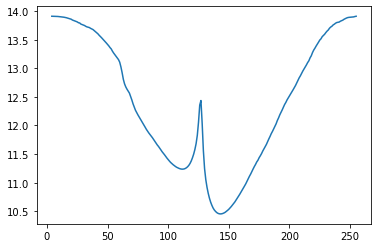

In [31]:

o,b = myOtsu(ss)
plt.plot(o[:,0],o[:,1])
print(b)

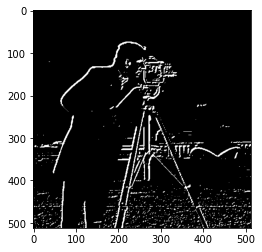

In [32]:
ss2 = ss.copy()
idx = ss < b[0]
ss2[idx] = 0
ss2[~idx] = 1
plt.imshow(ss2,'gray')

In [42]:
from PIL import ImageFilter as imf

In [44]:
type(im)

PIL.TiffImagePlugin.TiffImageFile

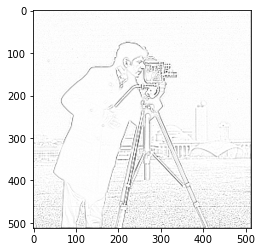

In [50]:
im1 = np.asarray(im.filter(imf.CONTOUR))
plt.imshow(im1,'gray')

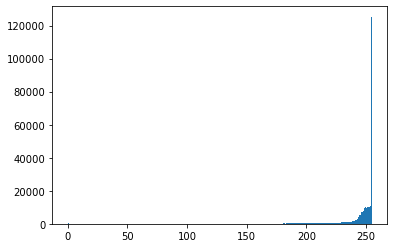

In [52]:
plt.hist(im1.ravel(),bins=256);

[231.           9.55716783]


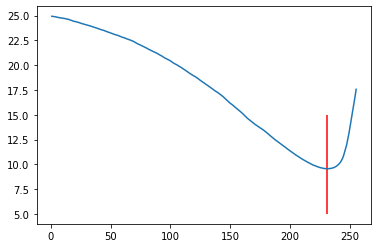

In [60]:
o,b = myOtsu(im1)
plt.plot(o[:,0],o[:,1])
plt.vlines(b[0],5,15,'r')
print(b)

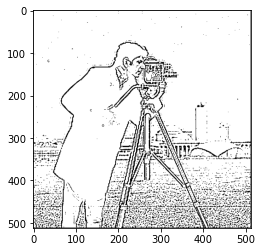

In [54]:
ss2 = im1.copy()
idx = im1 < b[0]
ss2[idx] = 0
ss2[~idx] = 1
plt.imshow(ss2,'gray')